In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install scipy==1.2.1
import scipy
print(scipy.__version__)

     |████████████████████████████████| 24.8 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
1.2.1


In [3]:
import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

Load train reviews and translate to English

In [ ]:
REVIEWS_TRAIN_JSON_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/train.json'

# create a pandas dateframe from reviews file
data = pd.read_json(REVIEWS_TRAIN_JSON_PATH, orient='records')

In [ ]:
!pip install deep-translator

In [ ]:
from deep_translator import GoogleTranslator

to_translate = 'Vreau sa traduc acest text'

translated = GoogleTranslator(source='ro', target='en').translate(to_translate)
print(translated)

In [ ]:
def translate(text):
  try:
    translated_text = GoogleTranslator(source='ro', target='en').translate(text)
  except:
    translated_text = text
    print('Text is too long')
  
  return translated_text

In [ ]:
data['translated text'] = data['text'].apply(translate)

In [ ]:
TRANSLATED_REVIEWS_DF_FILE_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/translated_train.pkl'
data.to_pickle(TRANSLATED_REVIEWS_DF_FILE_PATH)

Load already translated reviews file

In [4]:
TRANSLATED_REVIEWS_DF_FILE_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/translated_train.pkl'
data = pd.read_pickle(TRANSLATED_REVIEWS_DF_FILE_PATH)
data.tail()

,text,rating,id,translated text
24040,O porcarie de calcator l-am achizitionat acum ...,1,1507,I bought a computer piece of shit a week ago f...
24041,App are si sonda de temperatura + un prog care...,5,17958,The app also has a temperature probe + a prog ...
24042,Este un joc foarte bun cu o grafica excelenta ...,4,6789,It is a very good game with excellent graphics...
24043,Cablul de alimentare este foarte scurt daca a...,1,245,The power cord is very short if you have plugs...
24044,Pro: Merita la pretul asta Contra: Inca nu + n...,5,23737,Pros: It's worth it Cons: I'm not a profession...


Split the data set into train and validation sets (80% train, 20% validation)

In [5]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(data, test_size=.2)

In [6]:
train_dataset.head()

,text,rating,id,translated text
16256,Pro: Isi face treaba Contra: E voluminos Altel...,4,7931,Pros: It does its job Cons: It's bulky Other: ...
15140,Este un aparat de tuns versatil care imbina d...,5,17073,It is a versatile hair clipper that combines m...
17777,Foarte multumita de produs Toate accesoriile ...,5,12091,Very satisfied with the product All accessorie...
12710,Am achizitionat atat eu cat si un vecin acelas...,2,2467,I and a neighbor bought the same Phillips TV m...
9486,Nu prea purifica Deci in primele 20h mirose...,3,3293,It doesn't purify much. So in the first 20 hou...


,translated text,rating
16256,Pros: It does its job Cons: It's bulky Other: ...,4
15140,It is a versatile hair clipper that combines m...,5
17777,Very satisfied with the product All accessorie...,5
12710,I and a neighbor bought the same Phillips TV m...,2
9486,It doesn't purify much. So in the first 20 hou...,3


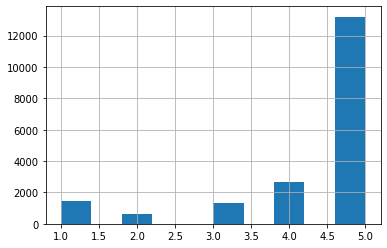

In [7]:
train = train_dataset[['translated text', 'rating']]
train['rating'].hist();train.head()

Break the 'rating' column into 5 binary columns 

In [8]:
train = pd.get_dummies(train, columns = ['rating'])
train.head()

,translated text,rating_1,rating_2,rating_3,rating_4,rating_5
16256,Pros: It does its job Cons: It's bulky Other: ...,0,0,0,1,0
15140,It is a versatile hair clipper that combines m...,0,0,0,0,1
17777,Very satisfied with the product All accessorie...,0,0,0,0,1
12710,I and a neighbor bought the same Phillips TV m...,0,1,0,0,0
9486,It doesn't purify much. So in the first 20 hou...,0,0,1,0,0


In [9]:
test = validation_dataset[['translated text', 'rating']]
test = pd.get_dummies(test, columns = ['rating'])

In [10]:
test.head()

,translated text,rating_1,rating_2,rating_3,rating_4,rating_5
20826,Pros: It does its job successfully I removed t...,0,0,0,0,1
23208,"Pros: Very ok, it's easy to play any game titl...",0,0,0,0,1
3962,Pros: Very good materials with quite a bit ove...,0,0,0,0,1
7397,"For sandwiches and waffles it is excellent, it...",0,0,0,1,0
16337,I start by giving it 5 stars It has some burne...,0,0,0,0,1


In [11]:
train.shape, test.shape

((19236, 6), (4809, 6))

# Neural Network Model

In [12]:
# use GLoVe word vectors to get pretrained word embeddings
embed_size = 200 
# max number of unique words 
max_features = 20000 #FIXME smaller number?
# max number of words from review to use
maxlen = 200

# word embeddings file path
embedding_file = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/glove_twitter_embeddings.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [13]:
class_names = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']
# splitting off y variable
y = train[class_names].values

In [14]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['translated text'].values))
X_train = tokenizer.texts_to_sequences(train['translated text'].values)
X_test = tokenizer.texts_to_sequences(test['translated text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [15]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [16]:
len(missed)

6449

In [17]:
missed[0:10]

["it's", '2', "don't", '3', '5', "i'm", "doesn't", '1', '4', '10']

Configure Model

In [42]:
MODEL_CHECKPOINT_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/lstm_weights_2.hdf5'

In [ ]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'softmax')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = MODEL_CHECKPOINT_PATH)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Fit Model

In [ ]:
model.fit(x_train, y, batch_size = 512, epochs = 20, validation_split = .1, callbacks=[earlystop, checkpoint])

Epoch 1/20
34/34 [==============================] - 13s 146ms/step - loss: 0.3886 - accuracy: 0.6834 - val_loss: 0.3398 - val_accuracy: 0.6840
Epoch 2/20
34/34 [==============================] - 4s 109ms/step - loss: 0.3323 - accuracy: 0.6868 - val_loss: 0.3263 - val_accuracy: 0.6840
Epoch 3/20
34/34 [==============================] - 4s 113ms/step - loss: 0.3148 - accuracy: 0.6873 - val_loss: 0.2942 - val_accuracy: 0.6923
Epoch 4/20
34/34 [==============================] - 4s 109ms/step - loss: 0.2899 - accuracy: 0.7002 - val_loss: 0.2782 - val_accuracy: 0.7069
Epoch 5/20
34/34 [==============================] - 4s 109ms/step - loss: 0.2766 - accuracy: 0.7096 - val_loss: 0.2614 - val_accuracy: 0.7126
Epoch 6/20
34/34 [==============================] - 4s 109ms/step - loss: 0.2631 - accuracy: 0.7170 - val_loss: 0.2562 - val_accuracy: 0.7188
Epoch 7/20
34/34 [==============================] - 4s 108ms/step - loss: 0.2548 - accuracy: 0.7261 - val_loss: 0.2522 - val_accuracy: 0.7136
Epoch

Evaluate Model

In [ ]:
y_test = model.predict([x_test], batch_size=1024, verbose = 1)

5/5 [==============================] - 4s 39ms/step


In [ ]:
y_test

array([[5.8378763e-03, 2.9677706e-02, 1.6810355e-01, 4.6599069e-01,
        2.8081334e-01],
       [1.4823307e-03, 2.7085904e-03, 1.9053128e-02, 2.8985816e-01,
        6.2543976e-01],
       [1.1420143e-03, 1.2393761e-03, 1.9566081e-03, 1.1775207e-02,
        9.8323202e-01],
       ...,
       [1.9208882e-04, 6.4233493e-04, 8.7462482e-04, 8.8209631e-03,
        9.9468428e-01],
       [1.2328845e-02, 6.1048202e-02, 3.5317105e-01, 4.1077963e-01,
        1.1928345e-01],
       [1.0383213e-02, 2.3529598e-02, 4.4678327e-02, 5.5855971e-02,
        8.9198399e-01]], dtype=float32)

In [ ]:
np.argmax(y_test)

17434

In [ ]:
model.evaluate(x_test, test[class_names].values, verbose = 1, batch_size=1024)

5/5 [==============================] - 0s 47ms/step - loss: 0.2312 - accuracy: 0.7607


[0.23115739226341248, 0.7606570720672607]

In [ ]:
v = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.61      0.71      0.66       364
           1       0.00      0.00      0.00       164
           2       0.32      0.32      0.32       330
           3       0.46      0.39      0.42       661
           4       0.87      0.92      0.90      3290

    accuracy                           0.76      4809
   macro avg       0.45      0.47      0.46      4809
weighted avg       0.73      0.76      0.74      4809



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save Model

In [25]:
MODEL_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/model_2.h5'
model.save(MODEL_PATH)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     4000000     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 200)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 80)      77120       ['spatial_dropout1d[0][0]']  

Load already trained model

In [43]:
import tensorflow as tf
from tensorflow import keras

MODEL_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/model_2.h5'

model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 200)     4000000     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 200, 200)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 200, 80)      77120       ['spatial_dropout1d[0][0]']  

# Predict Ratings for Reviews

Load reviews to be predicted

In [36]:
TEST_REVIEWS_JSON_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/test_wor.json'
test_data = pd.read_json(TEST_REVIEWS_JSON_PATH, orient='records')

In [37]:
len(test_data)

5922

In [38]:
test_data.head()

,text,rating,id
0,Cea mai proasta achizitie dupa 2 luni nici nu...,0,835
1,Il folosesc doar pentru barbierit bateria ma ...,0,12643
2,il folosesc pentru a transfera muzica pe un mo...,0,6612
3,O tableta utila mai ales acum cand baietelul i...,0,20582
4,Casti destul de bune Se aud foarte foarte bin...,0,11035


Translate to English the reviews to be predicted

In [ ]:
!pip install deep-translator

     |████████████████████████████████| 97 kB 4.9 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.3 which is incompatible.


In [ ]:
from deep_translator import GoogleTranslator

to_translate = 'Vreau sa traduc acest text'

translated = GoogleTranslator(source='ro', target='en').translate(to_translate)
print(translated)

I want to translate this text


In [ ]:
def translate(text):
  try:
    translated_text = GoogleTranslator(source='ro', target='en').translate(text)
  except:
    translated_text = text
    print('Text is too long')
  
  return translated_text

In [ ]:
test_data['translated text'] = test_data['text'].apply(translate)

TRANSLATED_TEST_REVIEWS_DF_FILE_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/translated_test.pkl'
test_data.to_pickle(TRANSLATED_TEST_REVIEWS_DF_FILE_PATH)

Text is too long
Text is too long
Text is too long
Text is too long


In [ ]:
test_data.tail()

,text,rating,id,translated text
5917,Am cumpărat acest aparat acum mai bine de o lu...,0,13070,I bought this device more than a month ago and...
5918,Raport calitate preț extraordinar la ce specif...,0,14612,Extraordinary price-performance ratio to what ...
5919,Un televizor foarte bun merita toti bani mai a...,0,20608,"A very good TV is worth all the money, especia..."
5920,Este usor mic portabil dar cam atat Desi l...,0,12365,"It's a little small, portable, but that's abou..."
5921,Am cumparat controllerul asta acum un an l-am...,0,755,I bought this controller a year ago I left it ...


In [46]:
import pandas as pd
TRANSLATED_TEST_REVIEWS_DF_FILE_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/translated_test.pkl'
test_data = pd.read_pickle(TRANSLATED_TEST_REVIEWS_DF_FILE_PATH) 
test_data.tail()

,text,rating,id,translated text
5917,Am cumpărat acest aparat acum mai bine de o lu...,0,13070,I bought this device more than a month ago and...
5918,Raport calitate preț extraordinar la ce specif...,0,14612,Extraordinary price-performance ratio to what ...
5919,Un televizor foarte bun merita toti bani mai a...,0,20608,"A very good TV is worth all the money, especia..."
5920,Este usor mic portabil dar cam atat Desi l...,0,12365,"It's a little small, portable, but that's abou..."
5921,Am cumparat controllerul asta acum un an l-am...,0,755,I bought this controller a year ago I left it ...


Process the data set for model predictions

In [47]:
# max number of unique words 
max_features = 20000 #FIXME smaller number?
# max number of words from review to use
maxlen = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(test_data['translated text'].values))
X_validations = tokenizer.texts_to_sequences(test_data['translated text'].values)
x_validations = pad_sequences(X_validations, maxlen = maxlen)

Predict ratings

In [48]:
predictions = model.predict([x_validations], batch_size=1024, verbose = 1)

6/6 [==============================] - 0s 59ms/step


In [49]:
predictions

array([[1.3688520e-01, 3.2174237e-02, 6.7350030e-02, 1.6400376e-01,
        5.9958673e-01],
       [4.1457653e-04, 1.4380399e-04, 5.7068683e-04, 2.9388194e-03,
        9.9593216e-01],
       [4.2544263e-03, 2.2908617e-03, 1.1559273e-02, 9.5148571e-02,
        8.8674688e-01],
       ...,
       [4.5820798e-05, 4.1260530e-05, 1.3281974e-04, 6.6204765e-04,
        9.9911803e-01],
       [2.4456419e-02, 3.5015002e-02, 1.7098397e-01, 4.9630326e-01,
        2.7324134e-01],
       [7.2163639e-06, 9.3911112e-06, 1.8449153e-05, 9.2119444e-05,
        9.9987280e-01]], dtype=float32)

Get the rating (the highest class probability) for each review

In [52]:
final_ratings = []

for prediction in predictions:
  final_ratings.append(np.argmax(prediction) + 1)

print(final_ratings)

[5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 5, 1, 5, 1, 4, 3, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 4, 5, 1, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 3, 5, 4, 5, 3, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 4, 5, 1, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 3, 1, 5, 5, 4, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 

Complete the data set with the rating for each review

In [53]:
for index, review in test_data.iterrows():
  test_data['rating'] = final_ratings[index]

test_data.head()  

,text,rating,id,translated text
0,Cea mai proasta achizitie dupa 2 luni nici nu...,5,835,Worst purchase after 2 months doesn't even sta...
1,Il folosesc doar pentru barbierit bateria ma ...,5,12643,I only use it for shaving the battery keeps me...
2,il folosesc pentru a transfera muzica pe un mo...,5,6612,I use it to transfer music to an FM modulator ...
3,O tableta utila mai ales acum cand baietelul i...,5,20582,A useful tablet especially now when the boy is...
4,Casti destul de bune Se aud foarte foarte bin...,5,11035,"Pretty good headphones They sound very, very g..."


In [54]:
test_data.tail()

,text,rating,id,translated text
5917,Am cumpărat acest aparat acum mai bine de o lu...,5,13070,I bought this device more than a month ago and...
5918,Raport calitate preț extraordinar la ce specif...,5,14612,Extraordinary price-performance ratio to what ...
5919,Un televizor foarte bun merita toti bani mai a...,5,20608,"A very good TV is worth all the money, especia..."
5920,Este usor mic portabil dar cam atat Desi l...,5,12365,"It's a little small, portable, but that's abou..."
5921,Am cumparat controllerul asta acum un an l-am...,5,755,I bought this controller a year ago I left it ...


Remove the auxiliary translated text column

In [57]:
final_data = test_data.drop('translated text', axis=1)
final_data.head()

,text,rating,id
0,Cea mai proasta achizitie dupa 2 luni nici nu...,5,835
1,Il folosesc doar pentru barbierit bateria ma ...,5,12643
2,il folosesc pentru a transfera muzica pe un mo...,5,6612
3,O tableta utila mai ales acum cand baietelul i...,5,20582
4,Casti destul de bune Se aud foarte foarte bin...,5,11035


Save the dataframe to a JSON file

In [59]:
FINAL_DATA_FILE_PATH = '/content/drive/MyDrive/Master/Anul 1/Semestrul 1/SII - Sisteme Internet Inteligente/Tema Predictie/test.json'
final_data.to_json(FINAL_DATA_FILE_PATH, orient='records')